In [2]:
from openai import OpenAI
import openai

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn import metrics as metrics
from scipy.special import expit
import seaborn as sns
from datasets.dataset_dict import DatasetDict
from datasets import Dataset
import torch
import pyarrow
from transformers import TrainingArguments, Trainer
from transformers import AutoTokenizer, AutoModel, TFAutoModel
from simpletransformers.classification import ClassificationModel
from simpletransformers.classification import ClassificationArgs
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import f1_score, accuracy_score
import warnings
warnings.filterwarnings('ignore')

seed = 9

ModuleNotFoundError: No module named 'openai'

In [58]:
client = OpenAI(api_key='sk-proj-6evO1Pdh91FWUAOQoZzqT3BlbkFJODxStygj2oaTYjP3Olq0')
# defaults to getting the key using os.environ.get("OPENAI_API_KEY")
# if you saved the key under a different environment variable name, you can do something like:
# client = OpenAI(
#   api_key=os.environ.get("CUSTOM_ENV_NAME"),
# )

In [1]:
completion = client.chat.completions.create(
  model="gpt-4o-mini"
  #model="gpt-3.5-turbo",
  messages=[
    {"role": "system", "content": "You are an expert in bias, stereotyping and discrimination. Your job is to classify sentences according to the following definition: a sentence is considered to contain bias when: the sentence contains bias, meaning a stereotype, exclusion, power imbalance or prejudice, either implicit or explicit AND that bias is is aimed against a specific group; OR the sentence contains a word that must be avoided according to the word list."},
    {"role": "user", "content": "Label the following sentence and explain your reasoning: the islam is an all-encompassing religion that controls every aspect of human existence."}
  ]
)

print(completion.choices[0].message)

NameError: name 'client' is not defined

In [67]:
# load data

dataset_path = "~/Projecten/programma-discriminatie-en-racisme/datasets/Datasets_2/"

test_df = pd.read_csv('test_df.csv')
new_test_df = pd.read_csv('new_test_df.csv')

for item in new_test_df['text']:
    print(item)

blank en haelermans, die in het antwoord op vraag 39 uitgebreid zijn aangehaald, concluderen op basis van hun onderzoek naar trends in onderwijsbureau- cratie dat het niet aannemelijk is dat schaalvergroting heeft bijgedragen aan meer management (2008: p.
met recht kunnen we spreken over illusies van fusies», concludeert hoogleraar jos blank.33 terwijl professionals in de publieke sector aan autonomie hebben ingeboet, zien wij bij sommige bedrijven juist het tegenovergestelde.
met recht kunnen we spreken over illusies van fusies», concludeert hoogleraar jos blank.33 terwijl professionals in de publieke sector aan autonomie hebben ingeboet, zien wij bij sommige bedrijven juist het tegenovergestelde.
niet-dossierstuk over de afgelopen twintig jaar wijst uit dat in het basisonderwijs het 2008–2009, 2009d31257. aantal managers vrij stabiel is gebleven (blank, j. en c.
blank en haelermans, die in het antwoord op vraag 39 uitgebreid zijn aangehaald, concluderen op basis van hun onderzoek naa

In [82]:
predictions = []

for item in test_df['text']:
    completion = client.chat.completions.create(
      model="gpt-3.5-turbo",
      messages=[
        {"role": "system", "content": "Je bent een expert op het gebied van bias, stereotypering en discriminatie. Je taak is om zinnen te classificeren volgens de volgende definitie: een zin bevat bias als de zin een stereotype, uitsluiting, machtsverhoudingen of vooroordelen bevat, die impliciet of expliciet kunnen zijn, en die gaan over een af te bakenen groep personen, OF als een zin een woord bevat wat moet worden vermeden omdat het bias bevat."},
        {"role": "user", "content": f"Geef de volgende zin een label, antwoord alleen met 0 of 1. Geef de zin het label 0 voor niet-biased en 1 voor biased. De zin is: '{item}'"}
      ]
    )
    
    answer = completion.choices[0].message.content
    predictions.append(answer)
    
print(predictions)
# predictions = ['0', '1', '1 ', '0', '0', '1', '0', '0', '0', '0', '0', '1', '1', '0', '1', '1', '1', '0', '1', '1', '0', '1', '1', '0', '1', '1', '1', '0', '1', '1', '0', '1', '1', '1', '0', '0', '0', '1', '0', '1', '0', '1', '0', '0', '0', '1', '1', '1', '1', '0', '1', '1', '0', '0', '1', '1', '1', '0', '0', '1', '0', '0', '0', '1', '0', '1', '1', '1', '0', '1', '1', '0', '0', '1', '1', '1', '0', '0', '1', '0', '0', '0', '0', '0', '0', '1', '1', '0', '0', '1', '0', '1', '0', '1', '1', '1', '0', '1', '1', '1', '0', '0', '1', '0', '1', '1', '0', '0', '0', '0', '1', '1', '0', '1', '1', '1', '1', '0', '1', '1', '1', '1', '1', '0', '0', '1', '1', '0', '1', '0', '1', '1', '1', '1', '1', '0', '1', '1', '0', '1', '0', '1', '0', '1', '0', '0', '0', '1', '1', '0', '0', '0', '1', '1', '1', '1', '0', '0', '1', '0', '1', '0', '0', '0', '1', '1', '0', '1', '1', '0', '1', '1', '1', '1', '0', '1', '1', '0', '1', '0', '0', '0', '0', '0', '0', '1', '1', '0', '1', '1', '1', '1', '1', '0', '1', '0', '1', '1', '1', '1', '1', '1', '0', '0', '1', '0', '0', '0', '0', '1', '1', '0', '0', '0', '0', '1', '1', '0', '0', '1', '1', '0', '1', '0', '1', '0', '1', '0', '1', '1', '1', '0', '1', '1', '1', '1', '0', '0', '1', '1', '0', '1', '0', '1', '1', '1', '0', '0', '1', '1', '1', '1', '0', '1', '1', '1', '1', '0', '0', '1', '1', '1', '1', '1', '1', '0', '1', '1', '1', '0', '0', '1', '1', '1', '1', '1', '1', '1', '1', '0', '0', '1', '1', '1', '0', '1', '0', '1', '1', '1', '0', '0', '1', '1', '0', '1', '1', '1', '0', '1', '0', '1', '1', '1', '0', '0', '1', '1', '1', '0', '1', '1', '0', '1', '1', '0', '1', '1', '1', '1', '1', '0', '1', '1', '0', '1', '1', '0', '0', '1', '1', '0', '1', '0', '1', '0', '0', '0', '0', '0', '0', '1', '0', '1', '0', '1', '1', '0', '1', '1', '1', '1', '0', '0', '0', '1', '1', '0', '0', '1', '1', '0', '0', '0', '1', '0', '1', '0', '1', '1', '0', '0', '1', '0', '1', '1', '0', '0', '0', '1', '1', '0', '1', '1', '0', '0', '0', '0', '1', '1', '1', '0', '1', '0', '1', '0', '0', '0', '0', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '0', '1', '0', '1', '1', '1', '1', '1', '1', '1', '1', '0', '0', '0', '1', '1', '1', '0', '0', '1', '0', '1', '1', '1', '1', '1', '1', '1', '1', '1', '0', '1', '1', '1', '0', '1', '0', '1', '1', '1', '1', '1', '1', '1', '1', '1', '0', '1', '0', '0', '1', '0', '0', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '0', '1', '0', '0', '1', '1', '1', '0', '1', '1', '0', '0', '0', '1', '0', '1', '1', '0', '1', '0', '0', '0', '1', '1', '1', '1', '0', '0', '0', '1', '1', '0', '0', '1', '1', '1', '0', '0', '1', '0', '1', '1', '1', '1', '1', '1', '0', '1', '1', '0', '0', '1', '1', '0', '0', '0', '1', '0', '0', '1', '1', '1', '1', '0', '0', '0', '0', '0', '0', '1', '1', '1', '0', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '0', '1', '0', '0', '0', '0', '1', '1', '0', '1', '1', '0', '0', '0', '0', '1', '1', '1', '0', '1', '0', '1', '0', '1', '1', '1', '0', '1', '1', '1', '1', '0', '0', '0', '1', '1', '0', '1', '1', '1', '1', '1', '0', '1', '1', '1', '0', '0', '1', '1', '0', '1', '1', '1', '1', '0', '1', '0', '1', '0', '1', '0', '0', '0', '1', '0', '0', '1', '0', '1', '1', '0', '1', '0', '0', '0', '1', '0', '0', '1', '0', '1', '1', '1', '1', '0', '1', '0', '1', '1', '1', '1', '1', '0', '0', '0', '1', '0', '0', '0', '0', '1', '0', '1', '0', '1', '0', '1', '0', '0', '1', '0', '1', '0', '1', '1', '1', '1', '0', '0', '1', '1', '1', '1', '1', '1', '1', '1', '0', '1', '1', '1', '0', '1', '1', '1', '1', '1', '0', '0', '0', '1', '0', '1', '1', '1', '0', '0', '1', '1', '1', '1', '0', '1', '0', '1', '0', '0']

['0', '1', '1 ', '0', '0', '1', '0', '0', '0', '0', '0', '1', '1', '0', '1', '1', '1', '0', '1', '1', '0', '1', '1', '0', '1', '1', '1', '0', '1', '1', '0', '1', '1', '1', '0', '0', '0', '1', '0', '1', '0', '1', '0', '0', '0', '1', '1', '1', '1', '0', '1', '1', '0', '0', '1', '1', '1', '0', '0', '1', '0', '0', '0', '1', '0', '1', '1', '1', '0', '1', '1', '0', '0', '1', '1', '1', '0', '0', '1', '0', '0', '0', '0', '0', '0', '1', '1', '0', '0', '1', '0', '1', '0', '1', '1', '1', '0', '1', '1', '1', '0', '0', '1', '0', '1', '1', '0', '0', '0', '0', '1', '1', '0', '1', '1', '1', '1', '0', '1', '1', '1', '1', '1', '0', '0', '1', '1', '0', '1', '0', '1', '1', '1', '1', '1', '0', '1', '1', '0', '1', '0', '1', '0', '1', '0', '0', '0', '1', '1.', '0', '0', '0', '1', '1', '1', '1', '0', '0', '1', '0', '1', '0', '0', '0', '1', '1', '0', '1', '1', '0', '1', '1', '1', '1', '0', '1', '1', '0', '1', '0', '0', '0', '0', '0', '0', '1', '1', '0', '1', '1', '1', '1', '1', '0', '1', '0', '1', '1', '1', '1

In [84]:
#predictions = ['0', '1', '1 ', '0', '0', '1', '0', '0', '0', '0', '0', '1', '1', '0', '1', '1', '1', '0', '1', '1', '0', '1', '1', '0', '1', '1', '1', '0', '1', '1', '0', '1', '1', '1', '0', '0', '0', '1', '0', '1', '0', '1', '0', '0', '0', '1', '1', '1', '1', '0', '1', '1', '0', '0', '1', '1', '1', '0', '0', '1', '0', '0', '0', '1', '0', '1', '1', '1', '0', '1', '1', '0', '0', '1', '1', '1', '0', '0', '1', '0', '0', '0', '0', '0', '0', '1', '1', '0', '0', '1', '0', '1', '0', '1', '1', '1', '0', '1', '1', '1', '0', '0', '1', '0', '1', '1', '0', '0', '0', '0', '1', '1', '0', '1', '1', '1', '1', '0', '1', '1', '1', '1', '1', '0', '0', '1', '1', '0', '1', '0', '1', '1', '1', '1', '1', '0', '1', '1', '0', '1', '0', '1', '0', '1', '0', '0', '0', '1', '1', '0', '0', '0', '1', '1', '1', '1', '0', '0', '1', '0', '1', '0', '0', '0', '1', '1', '0', '1', '1', '0', '1', '1', '1', '1', '0', '1', '1', '0', '1', '0', '0', '0', '0', '0', '0', '1', '1', '0', '1', '1', '1', '1', '1', '0', '1', '0', '1', '1', '1', '1', '1', '1', '0', '0', '1', '0', '0', '0', '0', '1', '1', '0', '0', '0', '0', '1', '1', '0', '0', '1', '1', '0', '1', '0', '1', '0', '1', '0', '1', '1', '1', '0', '1', '1', '1', '1', '0', '0', '1', '1', '0', '1', '0', '1', '1', '1', '0', '0', '1', '1', '1', '1', '0', '1', '1', '1', '1', '0', '0', '1', '1', '1', '1', '1', '1', '0', '1', '1', '1', '0', '0', '1', '1', '1', '1', '1', '1', '1', '1', '0', '0', '1', '1', '1', '0', '1', '0', '1', '1', '1', '0', '0', '1', '1', '0', '1', '1', '1', '0', '1', '0', '1', '1', '1', '0', '0', '1', '1', '1', '0', '1', '1', '0', '1', '1', '0', '1', '1', '1', '1', '1', '0', '1', '1', '0', '1', '1', '0', '0', '1', '1', '0', '1', '0', '1', '0', '0', '0', '0', '0', '0', '1', '0', '1', '0', '1', '1', '0', '1', '1', '1', '1', '0', '0', '0', '1', '1', '0', '0', '1', '1', '0', '0', '0', '1', '0', '1', '0', '1', '1', '0', '0', '1', '0', '1', '1', '0', '0', '0', '1', '1', '0', '1', '1', '0', '0', '0', '0', '1', '1', '1', '0', '1', '0', '1', '0', '0', '0', '0', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '0', '1', '0', '1', '1', '1', '1', '1', '1', '1', '1', '0', '0', '0', '1', '1', '1', '0', '0', '1', '0', '1', '1', '1', '1', '1', '1', '1', '1', '1', '0', '1', '1', '1', '0', '1', '0', '1', '1', '1', '1', '1', '1', '1', '1', '1', '0', '1', '0', '0', '1', '0', '0', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '0', '1', '0', '0', '1', '1', '1', '0', '1', '1', '0', '0', '0', '1', '0', '1', '1', '0', '1', '0', '0', '0', '1', '1', '1', '1', '0', '0', '0', '1', '1', '0', '0', '1', '1', '1', '0', '0', '1', '0', '1', '1', '1', '1', '1', '1', '0', '1', '1', '0', '0', '1', '1', '0', '0', '0', '1', '0', '0', '1', '1', '1', '1', '0', '0', '0', '0', '0', '0', '1', '1', '1', '0', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '0', '1', '0', '0', '0', '0', '1', '1', '0', '1', '1', '0', '0', '0', '0', '1', '1', '1', '0', '1', '0', '1', '0', '1', '1', '1', '0', '1', '1', '1', '1', '0', '0', '0', '1', '1', '0', '1', '1', '1', '1', '1', '0', '1', '1', '1', '0', '0', '1', '1', '0', '1', '1', '1', '1', '0', '1', '0', '1', '0', '1', '0', '0', '0', '1', '0', '0', '1', '0', '1', '1', '0', '1', '0', '0', '0', '1', '0', '0', '1', '0', '1', '1', '1', '1', '0', '1', '0', '1', '1', '1', '1', '1', '0', '0', '0', '1', '0', '0', '0', '0', '1', '0', '1', '0', '1', '0', '1', '0', '0', '1', '0', '1', '0', '1', '1', '1', '1', '0', '0', '1', '1', '1', '1', '1', '1', '1', '1', '0', '1', '1', '1', '0', '1', '1', '1', '1', '1', '0', '0', '0', '1', '0', '1', '1', '1', '0', '0', '1', '1', '1', '1', '0', '1', '0', '1', '0', '0']

predictions_int = []

for item in predictions:
    predictions_int.append(int(item))
    
predictions = predictions_int

In [85]:
def f1_multiclass(labels, preds):
    return f1_score(labels, preds, average='macro')

f1_score = f1_multiclass(list(test_df['label']), predictions)
print(f1_score)

# 0.5593280444187767

0.5593280444187767


In [70]:
new_predictions = []

for item in new_test_df['text']:
    completion = client.chat.completions.create(
      model="gpt-3.5-turbo",
      messages=[
        {"role": "system", "content": "Je bent een expert op het gebied van bias, stereotypering en discriminatie. Je taak is om zinnen te classificeren volgens de volgende definitie: een zin bevat bias als de zin een stereotype, uitsluiting, machtsverhoudingen of vooroordelen bevat, die impliciet of expliciet kunnen zijn, en die gaan over een af te bakenen groep personen, OF als een zin een woord bevat wat moet worden vermeden omdat het bias bevat."},
        {"role": "user", "content": f"Geef de volgende zin een label, antwoord alleen met 0 of 1. Geef de zin het label 0 voor niet-biased en 1 voor biased. De zin is: '{item}'"}
      ]
    )
    
    answer = completion.choices[0].message.content
    new_predictions.append(int(answer))
    
print(new_predictions)
# new_predictions = ['0', '1', '1', '1', '1', '1', '1', '0', '0', '1', '1', '0', '1', '0', '1', '1', '0', '1', '1', '1', '0', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '0', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '0', '1', '1', '1', '1', '1', '1', '1', '1', '1', '0', '0', '0', '0', '0', '1', '0', '1', '0']

['0', '1', '1', '1', '1', '1', '1', '0', '0', '1', '1', '0', '1', '0', '1', '1', '0', '1', '1', '1', '0', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '0', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '0', '1', '1', '1', '1', '1', '1', '1', '1', '1', '0', '0', '0', '0', '0', '1', '0', '1', '0']


In [79]:
new_predictions_int = []

for item in new_predictions:
    new_predictions_int.append(int(item))
    
new_predictions = new_predictions_int

In [80]:
def f1_multiclass(labels, preds):
    return f1_score(labels, preds, average='macro')

f1_new = f1_multiclass(list(new_test_df['label']), new_predictions)
print(f1_new)

# 0.6329787234042553

0.6329787234042553


{'macht': 0.4931506849315068, 'migranten': 0.375, 'stromen': 0.6074766355140186, 'stroom': 0.7659574468085106, 'meisje': 0.7333333333333333, 'armoede': 0.4878048780487805, 'seksueel': 0.4794520547945205, 'transgender': 0.5, 'gehandicapt': 0.8064516129032258, 'mankracht': 0.5333333333333333, 'traditie': 0.5, 'hetero': 0.3, 'geslacht': 0.45454545454545453, 'hoogopgeleid': 0.875, 'ouders': 0.5882352941176471, 'kloof': 0.8, 'laagopgeleid': 0.8333333333333334, 'hoofddoek': 0.0, 'joods': 0.42857142857142855, 'afstromen': 0.875, 'racisme': 0.125, 'minderheden': 0.75, 'privilege': 0.4, 'nieuwkomer': 0.5, 'christen': 0.7, 'anderstalig': 0.6, 'islam': 0.75, 'zittenblijven': 0.2, 'slaaf': 0.4, 'jongen': 1.0, 'homo': 0.0, 'slavernijverleden': 0.6666666666666666, 'arabisch': 0.3333333333333333}


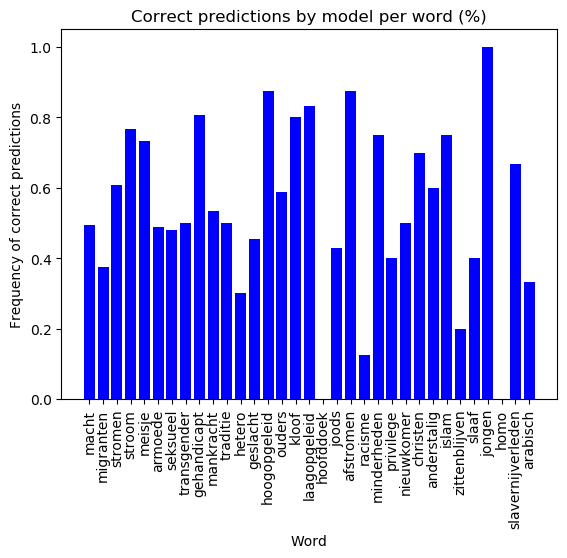

In [87]:
# kijken naar betrouwbaarheid per zoekwoord
test_df_words['predicted'] = predictions

dict_word_totals = {}
dict_word_correct = {}
dict_word_relative = {}

dict_label_totals = {}
dict_label_pos = {}
dict_label_relative = {}

for i in range(len(test_df_words)):
    woord = test_df_words['word'].iloc[i]
    label = test_df_words['label'].iloc[i]
    if woord not in dict_word_totals:
        dict_word_totals[woord] = 1
        dict_word_relative[woord] = 0
        dict_label_totals[woord] = 1
        dict_label_relative[woord] = 0
        
        if test_df_words['predicted'].iloc[i] == test_df_words['label'].iloc[i]:
            dict_word_correct[woord] = 1
        else:
            dict_word_correct[woord] = 0
        
        if label == 1:
            dict_label_pos[woord] = 1
        else:
            dict_label_pos[woord] = 0
            
    else:
        dict_word_totals[woord] += 1
        dict_label_totals[woord] +=1
        if test_df_words['predicted'].iloc[i] == test_df_words['label'].iloc[i]:
            dict_word_correct[woord] += 1
        if label == 1:
            dict_label_pos[woord] += 1
        
    dict_word_relative[woord] = dict_word_correct[woord]/dict_word_totals[woord]
    dict_label_relative[woord] = dict_label_pos[woord]/dict_label_totals[woord]
            
print(dict_word_relative)

n=len(dict_word_relative)
r = np.arange(n) 
width = 0.25

plt.bar(dict_word_relative.keys(), dict_word_relative.values(), color = 'blue')
#plt.bar(dict_label_relative.keys(), dict_label_relative.values(), color = 'blue')
plt.xticks(rotation=90)
plt.xlabel('Word')
plt.ylabel('Frequency of correct predictions')
plt.title('Correct predictions by model per word (%)')
plt.show()

# TODO: TOEVOEGEN HOE VEEL VAN DE WOORDEN EEN 1 ZIJN

{'blank': 0.0, 'opstromen': 0.0, 'slaven': 0.0, 'vluchtelingencrisis': 0.0, 'fobie': 0.0, 'thuiszitter': 0.0, 'achterstandsleerling': 0.0, 'juf': 0.0, 'verliefd': 0.0, 'inheems': 0.0, 'tussenpositie': 0.0, 'oostblok': 0.0}
{'blank': 0.0, 'opstromen': 0.8888888888888888, 'slaven': 1.0, 'vluchtelingencrisis': 0.875, 'fobie': 0.2, 'thuiszitter': 1.0, 'achterstandsleerling': 1.0, 'juf': 0.6666666666666666, 'verliefd': 0.75, 'inheems': 0.0, 'tussenpositie': 0.0, 'oostblok': 1.0}


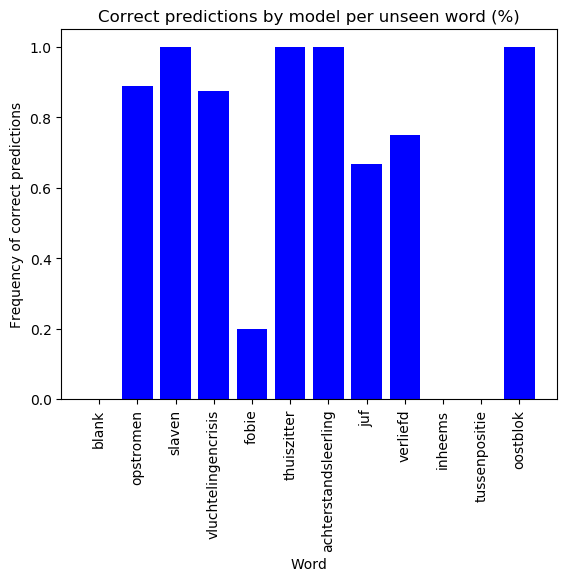

In [73]:
# kijken naar betrouwbaarheid per categorie
new_test_df['predicted'] = new_predictions

dict_word_totals = {}
dict_word_correct = {}
dict_word_relative = {}

dict_label_totals = {}
dict_label_pos = {}
dict_label_relative = {}

for i in range(len(new_words_data)):
    woord = new_words_data['word'].iloc[i]
    label = new_words_data['label'].iloc[i]
    if woord not in dict_word_totals:
        dict_word_totals[woord] = 1
        dict_word_relative[woord] = 0
        dict_label_totals[woord] = 1
        dict_label_relative[woord] = 0
        
        if new_test_df['predicted'].iloc[i] == new_test_df['label'].iloc[i]:
            dict_word_correct[woord] = 1
        else:
            dict_word_correct[woord] = 0
        
        if label == 1:
            dict_label_pos[woord] = 1
        else:
            dict_label_pos[woord] = 0
            
    else:
        dict_word_totals[woord] += 1
        dict_label_totals[woord] +=1
        if new_test_df['predicted'].iloc[i] == new_test_df['label'].iloc[i]:
            dict_word_correct[woord] += 1
        if label == 1:
            dict_label_pos[woord] += 1
        
    dict_word_relative[woord] = dict_word_correct[woord]/dict_word_totals[woord]
    dict_label_relative[woord] = dict_label_pos[woord]/dict_label_totals[woord]
            
print(dict_word_relative)
print(dict_label_relative)

n=len(dict_word_relative)
r = np.arange(n) 
width = 0.25

plt.bar(dict_label_relative.keys(), dict_label_relative.values(), color = 'blue')
#plt.bar(r+width, dict_label_relative.values(), color = 'blue')
plt.xticks(rotation=90)
plt.xlabel('Word')
plt.ylabel('Frequency of correct predictions')
plt.title('Correct predictions by model per unseen word (%)')

plt.show()

# TODO: TOEVOEGEN HOE VEEL VAN DE WOORDEN EEN 1 ZIJN

In [ ]:
### OUDE/NIET-WERKENDE CODE

In [49]:
def create_fine_tuning_dataset(df, discriminator=False, n_negative=1, add_related=False):
    """
    Create a dataset for fine tuning the OpenAI model; either for a discriminator model, 
    or a model specializing in Q&A, where it says if no relevant context is found.

    Parameters
    ----------
    df: pd.DataFrame
        The dataframe containing the question, answer and context pairs
    discriminator: bool
        Whether to create a dataset for the discriminator
    n_negative: int
        The number of random negative samples to add (using a random context)
    add_related: bool
        Whether to add the related contexts to the correct context. These are hard negative examples

    Returns
    -------
    pd.DataFrame
        The dataframe containing the prompts and completions, ready for fine-tuning
    """
    rows = []
    for i, row in df.iterrows():
        for q, a in zip(("1." + row.text).split('\n'), ("1." + row.label).split('\n')):
            if len(q) >10 and len(a) >10:
                if discriminator:
                    rows.append({"prompt":f"{row.context}\nQuestion: {q[2:].strip()}\n Related:", "completion":f" yes"})
                else:
                    rows.append({"prompt":f"{row.context}\nQuestion: {q[2:].strip()}\nAnswer:", "completion":f" {a[2:].strip()}"})

    for i, row in df.iterrows():
        for q in ("1." + row.questions).split('\n'):
            if len(q) >10:
                for j in range(n_negative + (2 if add_related else 0)):
                    random_context = ""
                    if j == 0 and add_related:
                        # add the related contexts based on originating from the same wikipedia page
                        subset = df[(df.title == row.title) & (df.context != row.context)]
                        
                        if len(subset) < 1:
                            continue
                        random_context = subset.sample(1).iloc[0].context
                    if j == 1 and add_related:
                        # add the related contexts based on the most similar contexts according to the search
                        random_context = get_random_similar_contexts(q[2:].strip(), row.context, search_model='ada', max_rerank=10)
                    else:
                        while True:
                            # add random context, which isn't the correct context
                            random_context = df.sample(1).iloc[0].context
                            if random_context != row.context:
                                break
                    if discriminator:
                        rows.append({"prompt":f"{random_context}\nQuestion: {q[2:].strip()}\n Related:", "completion":f" no"})
                    else:
                        rows.append({"prompt":f"{random_context}\nQuestion: {q[2:].strip()}\nAnswer:", "completion":f" No appropriate context found to answer the question."})

    return pd.DataFrame(rows) 

In [52]:
train_df.to_json(f'train_df.jsonl', orient='records', lines=True)
test_df.to_json(f'train_df.jsonl', orient='records', lines=True)

In [60]:
!openai tools fine_tunes.prepare_data -f train_df.jsonl

/bin/bash: openai: command not found


In [54]:
!pip show openai
!openai api fine_tunes.create -t "olympics-data/discriminator_train.jsonl" -v "olympics-data/discriminator_test.jsonl" --batch_size 16  --compute_classification_metrics --classification_positive_class " yes" --model ada

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
Name: openai
Version: 1.34.0
Summary: The official Python library for the openai API
Home-page: 
Author: 
Author-email: OpenAI <support@openai.com>
License: 
Location: /data/milenadeswart/.local/lib/python3.7/site-packages
Requires: anyio, cached-property, distro, httpx, pydantic, sniffio, tqdm, typing-extensions
Required-by: 
/bin/bash: openai: command not found
